# `rloop` sensor filter design notebook

We want to design filters to suppress wideband noise within our sensor readings without sacrificing sensor system responsiveness by blurring the readings too much.  In particular, we want strong stopband suppression while retaining good step response such that we can still react to changes from our sensors in a timely manner.  The requirements for sensor systems are different respective to the application of the particular sensor, and so we develop here a general framework that allows us to generate filter coefficients for each sensor parameterized by the maximum cutoff frequency, rise time, and sampling rate per system.

### Notebook info
This notebook was run using `python 3.6` on OSX, but should run anywhere you can install `python`, `numpy`, `scipy` and `matplotlib`.

In [43]:
%matplotlib inline
# Start with some setup, let's import the libraries we'll use to do our calculations
from numpy import *
from scipy import *
from scipy.signal import *
from matplotlib.pyplot import *
import csv

# Filter Type I: FIR Filters

FIR (Finite Impulse Response) filters are the simplest type of filter, calculating the output value off of a finite list of previous inputs.  Mathematically, we define:

$$
y[i] = \sum_{k=0}^{N}{x[i-k] \cdot b[k]}
$$

where $x$ is the array of input, $y$ is the array of output, and $b$ is a weights vector.  Our FIR filter design will find this weight vector through the application of window-based filter design.

In [2]:
# We define a function to spit out a filter design given three pieces of information:
#         fs: Sample rate in Hz
#        f_c: Cutoff frequency (in Hz)
#  rise_time: rise time (in seconds)
#
# Returns (b, a), but because this is an FIR filter, a is just [1], and b is the
# weight vector shown above
def fir_design(fs, fc, rise_time, window='nuttall'):
    # Given a rise time, we can immediately calculate the length of the filter;
    # A linear-phase FIR filter (which is what we're generating here) has a group
    # delay of (N-1)/(2*fs), where N is the length of the filter.  The group delay
    # tells us where the centroid of the impulse response will be (in seconds),
    # which also, by definition, corresponds to the 50% rise time point. A good
    # guess for N is therefore to invert the relation, and multiply by 1.5 to
    # hit the midpoint between the 50% rise time point, and 100%.  This is a
    # little bit more art than science, although we could just search over N
    # to find one that gives us a perfect result.
    N = round(1.5*(rise_time * fs + 1))
    
    return firwin(N, fc, window=window, nyq=fs/2.0), [1]

# Filter Type II: IIR Filters

IIR (Infinite Impulse Response) filters are a slightly more complicated type of filter, calculating the output value from a finie list of previous inputs as well as a finite list of previous outputs.  Mathematically, we define:

$$
y[i] = \sum_{k=0}^{N} {x[i-k] \cdot b[k]} + \sum_{j=1}^{M} {y[i-j] \cdot a[j]}
$$

where $x$ is the array of input, $y$ is the array of output, and $b$ and $a$ are weights vectors.  Our IIR filter design will find this weight vector through the use of a Bessel filter calculation routine, as Bessel filters are known to converge with a relative minimum of ringing.

In [3]:
# We define a function to spit out a filter design given three pieces of information:
#         fs: Sample rate in Hz
#        f_c: Cutoff frequency (in Hz)
#  rise_time: rise time (in seconds)
#
# Returns (b, a), the coefficients needed for filtering
def iir_design(fs, fc, rise_time):
    # Similar argument to the one above for fir_design(), but this has more to
    # do with "tried this value and it worked well" then any kind of math
    # argument.
    N = round(fs/2*rise_time)
    return bessel(N, fc/(fs/2))

# Filter testing rig

We will test our filters by examining the frequency response and the impulse/step response.  We are particularly interested in whether the spectral content above the cutoff frequency (in this case, 20 Hz) is adequately attentuated, and whether the rise time (the time after a step function activates until the filter output reaches 90% of the steady-state output) is within the specified threshold (in this case, 50ms)

In [87]:
def impulse_response(b, a, N):
    # If all we cared about were FIR filters, we could just use `b`.
    # But IIR it's easiest to just run an impulse through:
    impulse = hstack([1, zeros(N-1)])
    return lfilter(b, a, impulse)

def step_response(b, a, N):
    step = ones(N)
    return lfilter(b, a, step)

def db(x):
    return 20*log10(x)

def plot_filter(b, a, fs, L=100, name=None):
    # Calculate things like the impulse response, the frequency response, etc...
    imp_resp = impulse_response(b, a, L)
    step_resp = step_response(b, a, L)
    freq_resp = fft(imp_resp)
    freqs = arange(L/2)*fs/L
    times = arange(L)/fs
    
    # First, plot (positive, magnitude) frequency response
    subplot(221)
    plot(freqs, abs(freq_resp[:int(L/2)]), label=name)
    plot([20, 20], [0, 1], 'k--', alpha=0.5)
    xlim(0, fs/2)
    ylim(0, 1)
    xlabel('Frequency (Hz)')
    ylabel('Linear Frequency Response')
    legend()
    
    # Next, plot (positive, log-magnitude) frequency response
    subplot(222)
    plot(freqs, db(abs(freq_resp[:int(L/2)])), label=name)
    plot([20, 20], [-80, 0], 'k--', alpha=0.5)    
    xlim(0, fs/2)
    ylim(-80, 0)
    xlabel('Frequency (Hz)')
    ylabel('Log Frequency Response')
    legend()
    
    # Next, plot impulse response
    subplot(223)
    plot(times*1000, imp_resp, label=name)
    xlabel('Time (ms)')
    ylabel('Impulse Response')
    xlim(0, 100)
    ylim(min(imp_resp), 1)
    legend()
    
    # And also step response
    subplot(224)
    plot(times*1000, step_resp, label=name)
    plot([50, 50], [0, 1], 'k--', alpha=0.5)
    xlabel('Time (ms)')
    ylabel('Step Response')
    xlim(0, 100)
    ylim(-.1, 1.1)
    legend()

# FIR and IIR results

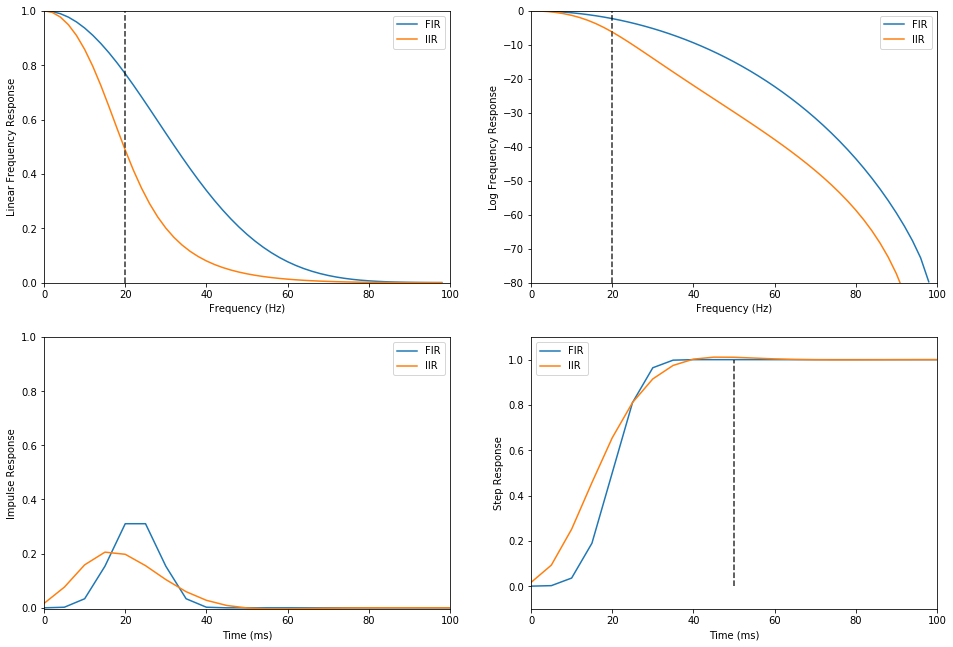

In [88]:
# We sample at 200 Hz, we want to preserve spectral energy under 20 Hz,
# and we need to see a change in at least 50 ms, although we shoot for faster
fs = 200
f_c = 20
rise_time = .03

b_fir, a_fir = fir_design(fs, f_c, rise_time)
b_iir, a_iir = iir_design(fs, f_c, rise_time)

figure(figsize=(16,11))
plot_filter(b_fir, a_fir, fs, name="FIR")
plot_filter(b_iir, a_iir, fs, name="IIR")

In [83]:
# Let's print out the filter coefficients as well
b_fir_str = ",".join(["%.12f"%(x) for x in b_fir])
print("FIR coefficients of length %d:\n  h: [%s]"%(len(b_fir), b_fir_str))
print()

a_iir_str = ",".join(["%.12f"%(x) for x in a_iir])
b_iir_str = ",".join(["%.12f"%(x) for x in b_iir])
print("IIR coefficients of length %d:\n  a: [%s]\n  b: [%s]"%(len(b_iir), a_iir_str, b_iir_str))

FIR coefficients of length 10:
  h: [0.000013414653,0.002226724484,0.033512055998,0.153692606820,0.310555198046,0.310555198046,0.153692606820,0.033512055998,0.002226724484,0.000013414653]

IIR coefficients of length 4:
  a: [1.000000000000,-1.643624635772,0.984122894170,-0.208891246861]
  b: [0.016450876442,0.049352629327,0.049352629327,0.016450876442]


# Synthetic Tests

We build a synthetic testing signal, add some Gaussian White Noise to it and see what it looks like

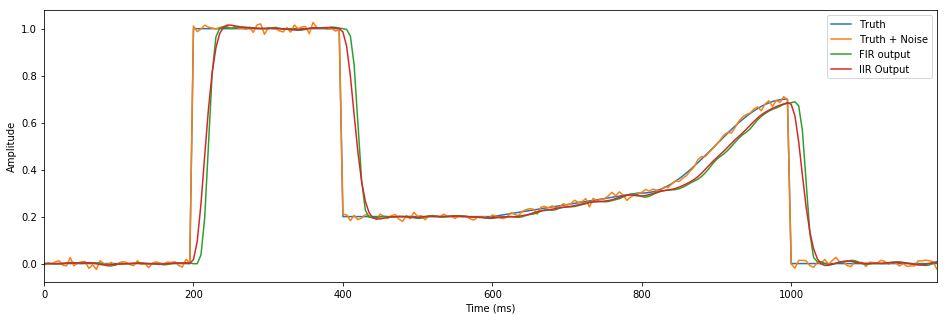

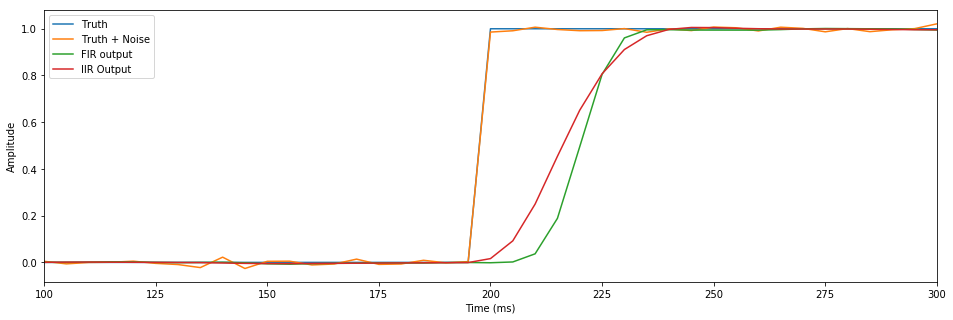

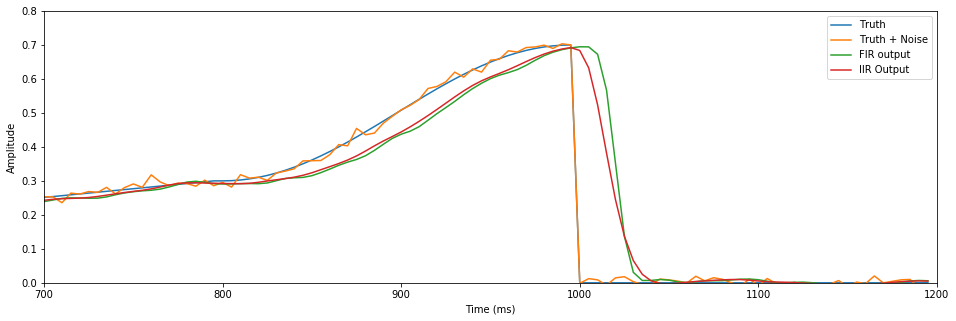

In [84]:
def plot_filtered_signal(truth):
    # We assume a sampling rate of 200 Hz, to stay consistent
    fs = 200
    # t is in milliseconds
    t = arange(len(truth))*1000/fs
    noisy = truth + .01*randn(len(truth))

    fir_filt = lfilter(b_fir, a_fir, noisy)
    iir_filt = lfilter(b_iir, a_iir, noisy)

    figure(figsize=(16,5))
    plot(t, truth)
    plot(t, noisy)
    plot(t, fir_filt)
    plot(t, iir_filt)
    xlim(0, t[-1])
    xlabel("Time (ms)")
    ylabel("Amplitude")
    legend(["Truth", "Truth + Noise", "FIR output", "IIR Output"])

# Generate test data
N = 40
ground_truth = hstack([
    zeros(N),
    1*ones(N),
    .2*ones(N),
    linspace(.2, .3, N),
    .2*(1 - cos(linspace(0,pi,N))) + .3,
    zeros(N)
])
plot_filtered_signal(ground_truth)

# Make a second plot, zoom in on first discontinuity
plot_filtered_signal(ground_truth)
xlim(100, 300)

# Make a third plot, zoom in on sin ramp
plot_filtered_signal(ground_truth)
xlim(700, 1200)
ylim(0, .8);

# Naturalistic Tests

We load in some .csv files containing actual Accelerometer data to see what they look like, and to run them through some of our filters.

In [85]:
csv_path = os.path.join("..", "..", "TEST_DATA", "2016_11_17", "accel_laser_data.csv")

# These channels informed by `filter_laser_data.py` in the `TEST_DATA/2016_11_17` folder.
accel_data = {
    'x': [],
    'y': [],
    'z': [],
}
laser_data = {
    'l_aft_height': [],
    'r_aft_height': [],
    'aft_yaw': [],
}
with open(csv_path, "r") as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        accel_data['x'].append(float(row[1]))
        accel_data['y'].append(float(row[2]))
        accel_data['z'].append(float(row[3]))
        laser_data['l_aft_height'].append(float(row[4]))
        laser_data['r_aft_height'].append(float(row[5]))
        laser_data['aft_yaw'].append(float(row[6]))

for k in accel_data.keys():
    accel_data[k] = array(accel_data[k])
for k in laser_data.keys():
    laser_data[k] = array(laser_data[k])

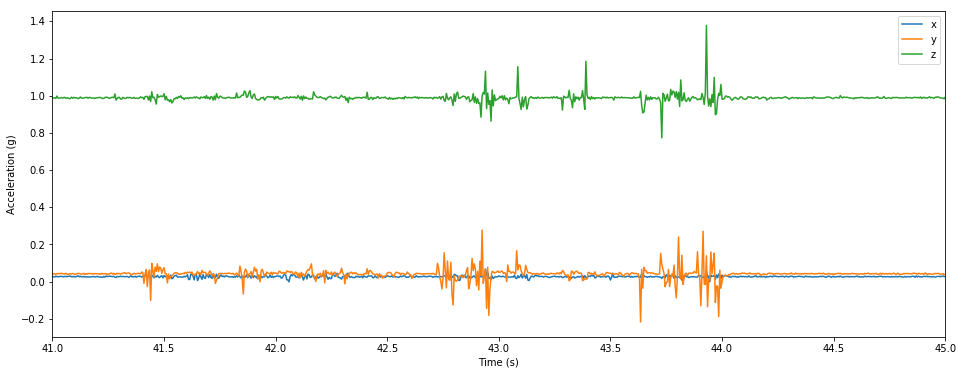

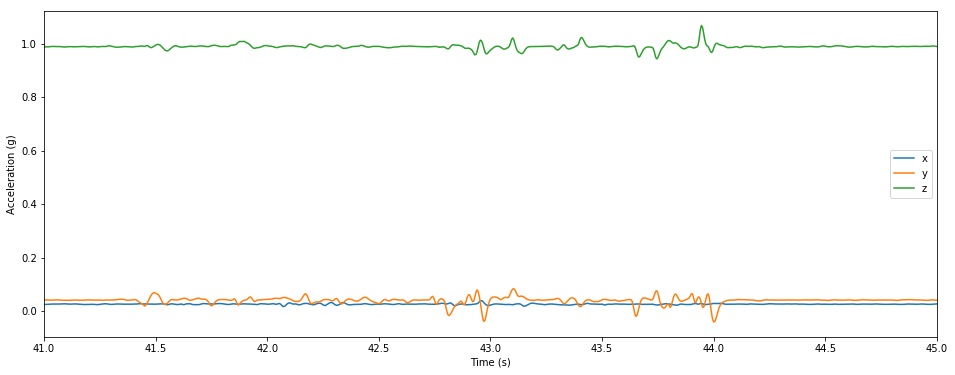

In [89]:
# We assume sampling rate of 200 Hz
fs = 200

def plot_dict(data):
    figure(figsize=(16,6))
    for k in data.keys():
        t = arange(len(data[k]))/fs
        plot(t, data[k], label=k)
        legend()
        
def filter_dict(b, a, data):
    return {k: lfilter(b, a, data[k]) for k in data.keys()}
    
    
# Plot the data, but manually zoom in on something interesting
plot_dict(accel_data)
xlim(41, 45)
xlabel('Time (s)')
ylabel('Acceleration (g)');

iir_accel_data = filter_dict(b_iir, a_iir, accel_data)
plot_dict(iir_accel_data)
xlim(41, 45)
xlabel('Time (s)')
ylabel('Acceleration (g)');